## This Notebook compares loss functions, foundational encoder training datasets, and encoder sizes.

### Findings:
1. Out of BCE, Focal loss, and Jaccard loss, Jaccard loss gives the best performance
2. The foundational dataset upon which the encoder was pretrained does not seem to matter very much for this task.
3. The encoder size does not impact performance. This indicates that the smaller model has enough capacity to reach convergence. As a general rule, you should always use the smallest possible model that converges to prevent overfitting.
4. Due to the current transformer hype, we tried using a shifted window transformer. It didn't work well.

### Takeaway:

Use a ResNet18 backbone with Jaccard Loss. Any pretrained ResNet18 is fine.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import torch
import os
import gc
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam
from typing import List, Dict
from torch.utils.data import DataLoader
from data import MemmapDataset
from tqdm import tqdm
from models import *
from loss import JaccardLoss
from torchvision.models import resnet18, resnet50, ResNet18_Weights, ResNet50_Weights
from torchgeo.models import get_weight

/Users/gage/anaconda3/envs/i2sb/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Setup

In [3]:
DATA_SPLIT = 0.90
NUM_CHANNELS = 9
NUM_CLASSES = 1
INIT_LR = 0.001
NUM_EPOCHS = 20
BATCH_SIZE = 64
INPUT_IMAGE_SIZE = 256
THRESHOLD = 0.5

# define the path to each directory
BASE_DIR = "/Users/gage/Desktop"
IMAGE_DIR = BASE_DIR + "/256dataset_images_small.npy"
LABEL_DIR = BASE_DIR + "/256dataset_labels_small.npy"

dataset = MemmapDataset(np.load(IMAGE_DIR, 'r'), np.load(LABEL_DIR, 'r'))
print(f"Dataset containing {len(dataset)} images loaded.")

# Setup the device to be used for training and evaluation
if torch.cuda.is_available():
    DEVICE = torch.device("cuda")
    print("Using CUDA device.")
elif torch.backends.mps.is_available():
    DEVICE = torch.device("mps")
    print("Using Apple Metal Performance Shaders (MPS) device.")
else:
    DEVICE = torch.device("cpu")
    print("No GPU found. Defaulting to CPU.")


trainDS, testDS = dataset.split(0.9)                           
# calculate steps per epoch for training and test set #config
TRAIN_STEPS = len(trainDS) // BATCH_SIZE
TEST_STEPS = len(testDS) // BATCH_SIZE

# create the training and test data loaders #config
trainLoader = DataLoader(trainDS, shuffle=True,
                         batch_size=BATCH_SIZE)
testLoader = DataLoader(testDS, shuffle=False,
                        batch_size=BATCH_SIZE)


del trainDS, testDS, dataset

Dataset containing 22317 images loaded.
Using Apple Metal Performance Shaders (MPS) device.


In [4]:
# Training Functions
def train(model, trainLoader : DataLoader, testLoader : DataLoader, lossFunc, NUM_EPOCHS=NUM_EPOCHS, print_all_epochs = False):
  opt = Adam(model.parameters(), lr=INIT_LR)
  # loop over epochs #config
  print("[INFO] training the network...")
  training_loss = []
  all_metrics = []

  for e in tqdm(range(NUM_EPOCHS)):
    # set the model in training mode
    model.train()
    totalTrainLoss = 0

    # loop over the training set
    for (i, (x, y)) in enumerate(trainLoader):
      # send the input to the device
      x = x.to(DEVICE)
      y = y.to(DEVICE).float()
      # perform a forward pass and calculate the training loss
      pred = model(x)
      if isinstance(pred, tuple):
        pred = pred[0]
      loss = lossFunc(pred, y)

      # first, zero out any previously accumulated gradients, then
      # perform backpropagation, and then update model parameters
      opt.zero_grad()
      loss.backward()
      opt.step()

      # add the loss to the total training loss so far
      totalTrainLoss += loss.item()
    # calculate the average training
    avgTrainLoss = totalTrainLoss / TRAIN_STEPS
    training_loss.append(avgTrainLoss)

    # Evaluate on test dataset
    metrics = evaluate(model, testLoader, lossFunc)
    all_metrics.append(metrics)
    avgTestLoss = metrics['Loss']

    if (e + 1) % 5 == 0 or e == 0 or print_all_epochs:
      # print the model training and validation information
      print("EPOCH: {}/{}".format(e + 1, NUM_EPOCHS)) #config
      print("Train loss: {:.6f}, Test loss: {:.4f}".format(
          avgTrainLoss, avgTestLoss))
      print("\nValidation Metrics:")
      for k, v in metrics.items():
          if k != 'Loss':
            print(f"{k}: {v}")
      print("\n")
  return training_loss, all_metrics

def evaluate(model: nn.Module, dataloader: DataLoader, loss_func):
    model.eval()
    total_loss = 0
    total_TP = 0
    total_FP = 0
    total_FN = 0
    total_TN = 0
    total_landmass_captured = 0
    total_landmass_actual = 0

    with torch.no_grad():
        for (x, y) in dataloader:
            x = x.to(DEVICE)
            y = y.to(DEVICE).float()
            
            pred = model(x)
            if isinstance(pred, tuple):
                pred = pred[0]
            loss = loss_func(pred, y)
            total_loss += loss.item()

            pred = torch.sigmoid(pred).view(-1)
            y = y.view(-1)
            
            TP = (pred * y).sum().item()
            FP = ((1 - y) * pred).sum().item()
            FN = (y * (1 - pred)).sum().item()
            TN = ((1 - y) * (1 - pred)).sum().item()
        
            total_TP += TP
            total_FP += FP
            total_FN += FN
            total_TN += TN

            total_landmass_actual += y.sum().item()
            total_landmass_captured += pred.sum().item()

    total_landmass_captured = total_landmass_captured / total_landmass_actual if total_landmass_actual > 0 else 0
    avg_loss = total_loss / len(dataloader)
    precision = total_TP / (total_TP + total_FP) if (total_TP + total_FP) > 0 else 0
    recall = total_TP / (total_TP + total_FN) if (total_TP + total_FN) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
    iou = total_TP / (total_TP + total_FP + total_FN) if (total_TP + total_FP + total_FN) > 0 else 0
    accuracy = (total_TP + total_TN) / (total_TP + total_FP + total_FN + total_TN) if (total_TP + total_FP + total_FN + total_TN) > 0 else 0
    specificity = total_TN / (total_TN + total_FP) if (total_TN + total_FP) > 0 else 0

    metrics = {
        'Landmass Captured': total_landmass_captured,
        'Loss': avg_loss,
        'Precision': precision,
        'Recall': recall,
        'f1_score': f1_score,
        'IOU': iou,
        'Accuracy': accuracy,
        'Specificity': specificity
    }

    return metrics


In [4]:
# Plotting Functions
def plot_losses(title, training_loss, validation_loss, training_time=None, y_max=0.3):
  # scale losses to fit graph
  valid_loss = [min(x,y_max) for x in validation_loss]
  train_loss = [min(x, y_max) for x in training_loss]


  plt.figure()
  plt.plot(np.arange(1, NUM_EPOCHS+1), train_loss, label="train_loss")
  plt.plot(np.arange(1, NUM_EPOCHS+1), valid_loss, label="valid_loss")
  plt.title(title)
  plt.xlabel("Epoch")
  plt.ylabel("Loss")
  plt.legend(loc="upper right")
  if training_time is not None:
    plt.text(0, 0.3, f"Training Time: {training_time}")

  step = y_max / 10
  yticks = np.arange(0, y_max+step, step)  # Generate ticks from 0.025 to 0.3 with step 0.025
  plt.yticks(yticks)

  xticks = np.arange(2, NUM_EPOCHS+2, 2)  # Generate ticks from 0 to num_epochs with step 2
  plt.xticks(xticks)
  
  plt.show()

def plot_metrics(title: str, metric_dict: Dict, metrics: List = ['Precision', 'Recall', 'IOU']):
    plt.figure()
    for metric in metrics:
        plt.plot(np.arange(0, NUM_EPOCHS), [x[metric] for x in metric_dict], label=metric)
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Value")
    plt.legend(loc="lower right")

    yticks = np.arange(0.0, 1.1, 0.1)
    plt.yticks(yticks)

    xticks = np.arange(2, NUM_EPOCHS+2, 2)
    plt.xticks(xticks)
    
    plt.show()

def plot_loss_comparison(title, training_losses1, training_losses2, validation_losses1, validation_losses2, compare1 = "Satellite", compare2 = "ImageNet", y_max=0.3):
    # scale losses to fit graph
    valid_loss_sat = [min(x, y_max) for x in validation_losses1]
    train_loss_sat = [min(x, y_max) for x in training_losses1]
    valid_loss_img = [min(x, y_max) for x in validation_losses2]
    train_loss_img = [min(x, y_max) for x in training_losses2]
    
    plt.figure()
    plt.plot(np.arange(0, NUM_EPOCHS), train_loss_sat, label=f"Training loss {compare1}", color='orange')
    plt.plot(np.arange(0, NUM_EPOCHS), valid_loss_sat, label=f"Validation loss {compare1}", color='orange', linestyle='dashed')
    plt.plot(np.arange(0, NUM_EPOCHS), train_loss_img, label=f"Training loss {compare2}", color='teal')
    plt.plot(np.arange(0, NUM_EPOCHS), valid_loss_img, label=f"Validation loss {compare2}", color='teal', linestyle='dashed')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(loc="upper right")
    
    yticks = np.arange(0.025, 0.325, 0.025)  # Generate ticks from 0.025 to 0.3 with step 0.025
    plt.yticks(yticks)
    
    xticks = np.arange(2, NUM_EPOCHS+2, 2)  # Generate ticks from 0 to num_epochs with step 2
    plt.xticks(xticks)
    
    plt.show()

def plot_comparison_metrics(title, metrics: List[List[Dict]], titles: List[str], metrics_wanted = ['Precision', 'Recall', 'IOU']):
    
    extracted_metrics = []
    for i in range(len(titles)):
        metrics_add = []
        for k in metrics[i][-1]:
            if k in metrics_wanted:
                metrics_add.append(metrics[i][-1][k])
        extracted_metrics.append(metrics_add)

    print(extracted_metrics)

    # Create bar positions
    bar_width = 0.8 / len(titles)  # Adjust bar width based on number of titles
    r = np.arange(len(metrics_wanted))
    
    # Plotting the bar chart
    plt.figure(figsize=(10, 6))
    
    for i in range(len(titles)):
        plt.bar([x + i * bar_width for x in r], extracted_metrics[i], width=bar_width, edgecolor='grey', label=titles[i])
    
    # Adding labels
    plt.xlabel('Metrics', fontweight='bold')
    plt.ylabel('Values')
    plt.title(title)
    plt.xticks([r + bar_width * (len(titles) / 2) for r in range(len(metrics_wanted))], metrics_wanted)
    plt.ylim(0, 1.1)
    
    plt.legend()
    plt.show()

### Loss Comparison

We compare BCE, Jaccard, and Focal loss. Jaccard was found to perform the best overall based on IOU. Focal loss had very high precision, but low recall.

In [ ]:
loss = BCEWithLogitsLoss()

sat_resnet18_UNet_BCE = ResNet_UNet(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
sat_resnet18_train_BCE, sat_resnet18_metrics_BCE = train(sat_resnet18_UNet_BCE, trainLoader, testLoader, loss)
sat_resnet18_valid_BCE = [x['Loss'] for x in sat_resnet18_metrics_BCE]
del sat_resnet18_UNet_BCE

In [ ]:
loss = JaccardLoss()

resnet18_UNet_jaccard = ResNet_UNet(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
sat_resnet18_train_jaccard, sat_resnet18_metrics_jaccard = train(resnet18_UNet_jaccard, trainLoader, testLoader, loss, print_all_epochs=True)
sat_resnet18_valid_jaccard = [x['Loss'] for x in sat_resnet18_metrics_jaccard]
del resnet18_UNet_jaccard

In [ ]:
loss = FocalLoss(alpha=0.25,reduction='mean')

resnet18_UNet_focal = ResNet_UNet(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
resnet18_train_focal, resnet18_metrics_focal = train(resnet18_UNet_focal, trainLoader, testLoader, loss)
resnet18_valid_focal = [x['Loss'] for x in resnet18_metrics_focal]
del resnet18_UNet_focal

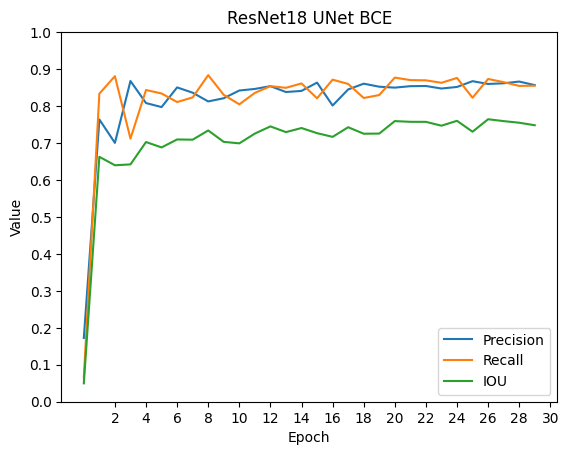

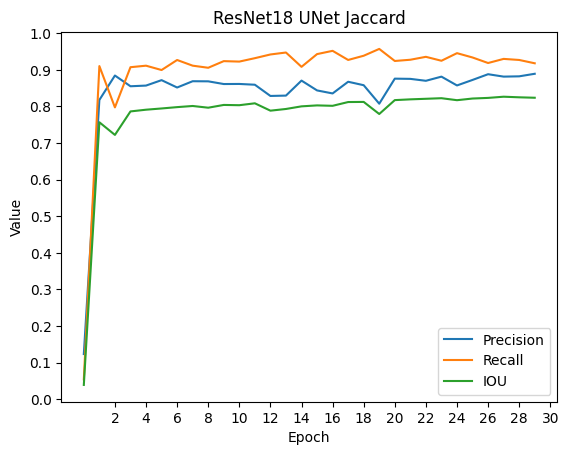

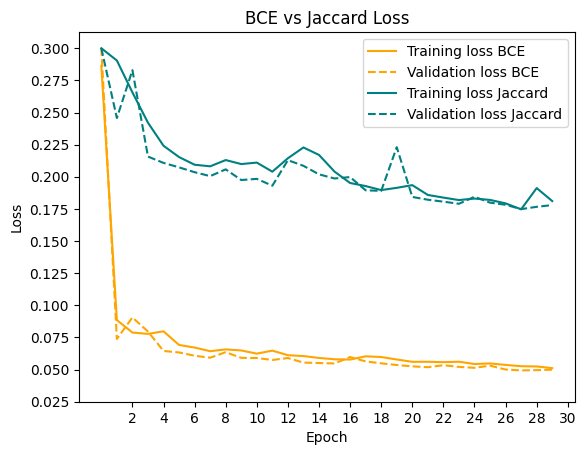

In [ ]:
plot_metrics("ResNet18 UNet BCE", sat_resnet18_metrics_BCE)
plot_metrics("ResNet18 UNet Jaccard", sat_resnet18_metrics_jaccard)
plot_loss_comparison("BCE vs Jaccard Loss", sat_resnet18_train_BCE, sat_resnet18_train_jaccard, sat_resnet18_valid_BCE, sat_resnet18_valid_jaccard, compare1='BCE', compare2='Jaccard')

Jaccard outperforms Binary Cross Entropy by all metrics even though BCE loss is much lower. This indicates that BCE loss is not as relevant to our desired model performance. 

We have a class imbalance, so we need to weight the classes differently or else the model will always predict majority class. Jaccard does that by emphasizing the IOU.

[[0.8566534713662922, 0.8550574675948277, 0.7480297689791253], [0.8892722772221734, 0.9179440480421696, 0.8237870146171179], [0.9764450329444468, 0.5688281580644384, 0.561128383248347]]


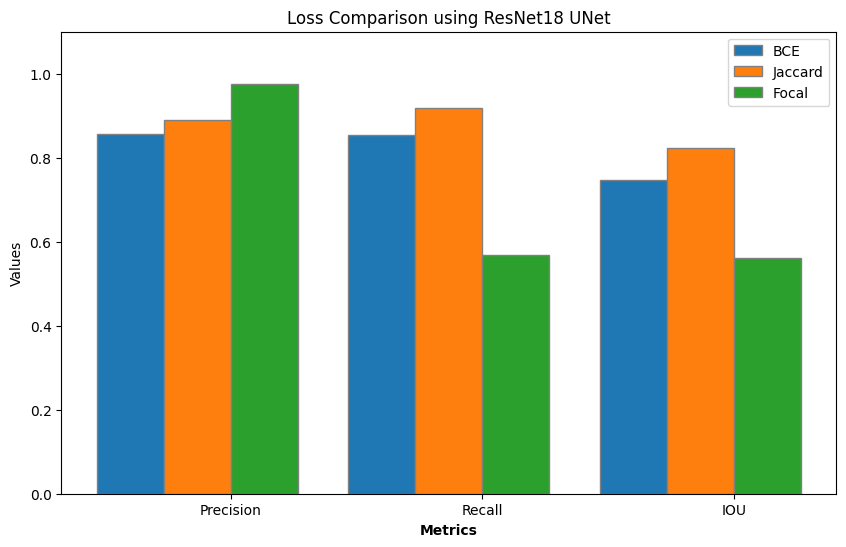

In [ ]:
# Loss Comparison
metrics = []
metrics.append(sat_resnet18_metrics_BCE)
metrics.append(sat_resnet18_metrics_jaccard)
metrics.append(resnet18_metrics_focal)

titles = ['BCE', 'Jaccard', 'Focal']

plot_comparison_metrics("Loss Comparison using ResNet18 UNet", metrics, titles)

In [ ]:
from models import ResNet_FC
loss = JaccardLoss()

sat_resnet18_FC_jaccard = ResNet_FC(input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
sat_resnet18_FC_train_jaccard, sat_resnet18_FC_metrics_jaccard = train(sat_resnet18_FC_jaccard, trainLoader, testLoader, loss)
sat_resnet18_FC_valid_jaccard = [x['Loss'] for x in sat_resnet18_FC_metrics_jaccard]
del sat_resnet18_FC_jaccard

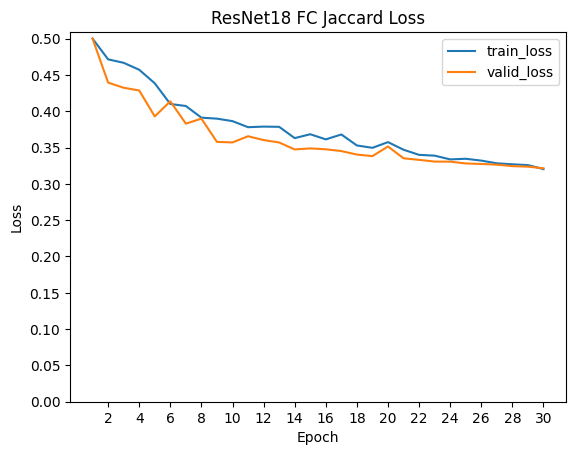

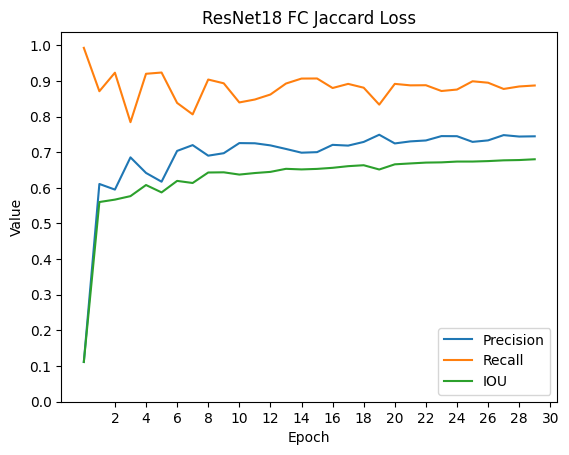

In [ ]:
plot_losses("ResNet18 FC Jaccard Loss", sat_resnet18_FC_train_jaccard, sat_resnet18_FC_valid_jaccard, y_max=0.5)
plot_metrics("ResNet18 FC Jaccard Loss", sat_resnet18_FC_metrics_jaccard)

This is without a UNet and just putting the ResNet output through a fully connected layer, similar to how the 2020 paper setup their architecture. It does not perform as well. 

### Imagenet vs Satellite Pretrained ResNet18 

In [ ]:
# This ResNet is pretrained on ImageNet 3-channel RGB images
imagenet_resnet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1).to(DEVICE)
loss = JaccardLoss()

imagenet_resnet18_unet = ResNet_UNet(ResNet=imagenet_resnet18, input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
del imagenet_resnet18
imagenet_resnet18_train, imagenet_resnet18_metrics = train(imagenet_resnet18_unet, trainLoader, testLoader, loss)
imagenet_resnet18_valid = [x['Loss'] for x in imagenet_resnet18_metrics]
del imagenet_resnet18_unet

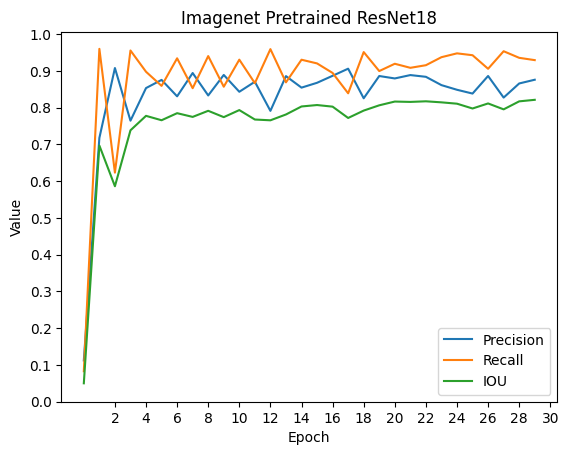

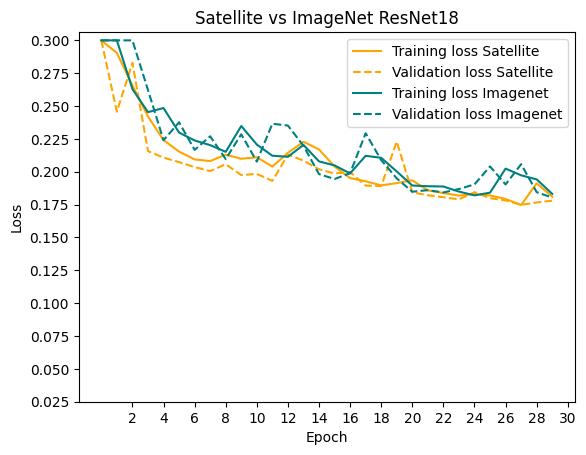

In [ ]:
#1:49
plot_metrics("Imagenet Pretrained ResNet18", imagenet_resnet18_metrics)
plot_loss_comparison("Satellite vs ImageNet ResNet18", sat_resnet18_train_jaccard, imagenet_resnet18_train, sat_resnet18_valid_jaccard, imagenet_resnet18_valid, compare1='Satellite', compare2='Imagenet')

Imagenet performs slightly worse than the satellite foundational model with the rest of the network the same. The difference is negligible, though. I don't think there is much benefit to using a satellite foundational model based on this, but it would not hurt to use it.

In [ ]:
torch.save(resnet18_UNet_jaccard.state_dict(), 'models/sat_resnet18_UNet_jaccard.pth') 

In [ ]:
# ImageNet vs Satellite ResNet18 FC
# This might be a more fair comparison than the UNet models,
# as the FC model is just a linear layer on top of the ResNet backbone.
imagenet18 = resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)

ImageNet_resnet18_FC = ResNet_FC(ResNet=imagenet18, input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
del imagenet18
ImageNet_resnet18_FC_train, ImageNet_resnet18_FC_metrics = train(ImageNet_resnet18_FC, trainLoader, testLoader, loss)
ImageNet_resnet18_FC_valid = [x['Loss'] for x in ImageNet_resnet18_FC_metrics]
del ImageNet_resnet18_FC

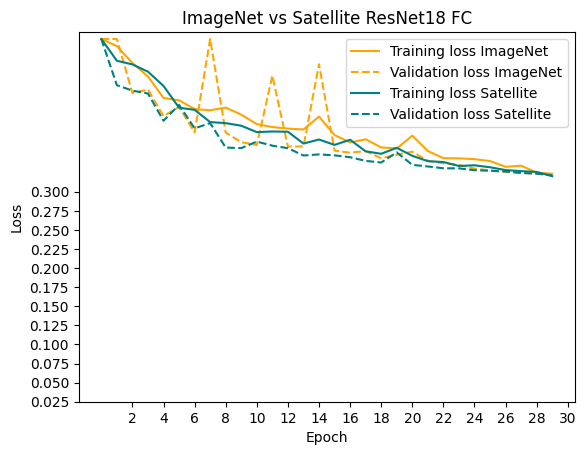

[[0.7415952260351034, 0.889851269934126, 0.6792427101893083], [0.7445986637279962, 0.8871447336722723, 0.6801716326202317]]


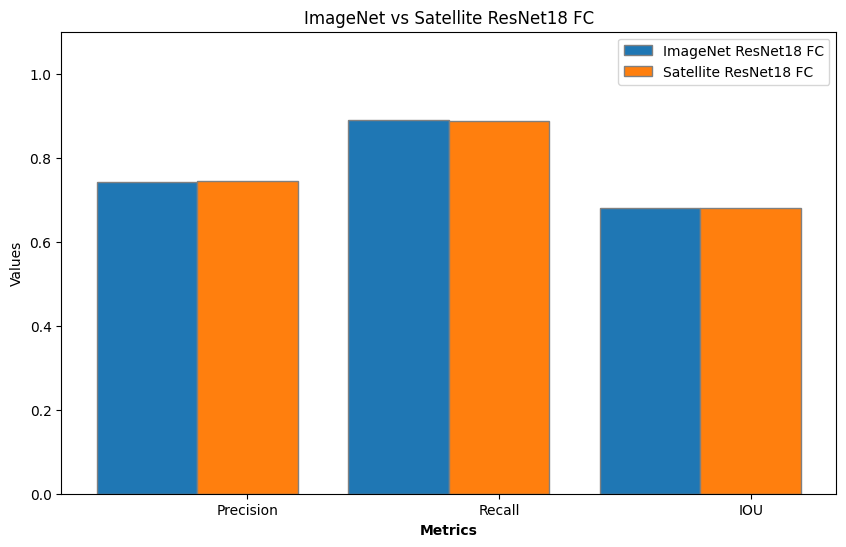

In [ ]:
plot_loss_comparison("ImageNet vs Satellite ResNet18 FC", ImageNet_resnet18_FC_train, sat_resnet18_FC_train_jaccard, ImageNet_resnet18_FC_valid, sat_resnet18_FC_valid_jaccard, compare1='ImageNet', compare2='Satellite', y_max=0.5)

# ImageNet vs Satellite ResNet18 FC Metrics
metrics = []
metrics.append(ImageNet_resnet18_FC_metrics)
metrics.append(sat_resnet18_FC_metrics_jaccard)

titles = ['ImageNet ResNet18 FC', 'Satellite ResNet18 FC']

plot_comparison_metrics("ImageNet vs Satellite ResNet18 FC", metrics, titles)

They're the same.

### ResNet50 vs ResNet18 Backbone UNet

In [ ]:
# U-Net model that uses a ResNet50 from SSL4EO-12. https://github.com/zhu-xlab/SSL4EO-S12
# The ResNet is pretrained on Sentinel-2 3-channel RGB satellite imagery
resnet50 = resnet50(weights=get_weight("ResNet50_Weights.SENTINEL2_RGB_SECO"))
loss = JaccardLoss()

sat_resnet50 = ResNet_UNet(ResNet=resnet50, input_image_size=INPUT_IMAGE_SIZE).to(DEVICE)
sat_resnet50_train, sat_resnet50_metrics = train(sat_resnet50, trainLoader, testLoader,loss)
sat_resnet50_valid = [x['Loss'] for x in sat_resnet50_metrics]
del sat_resnet50

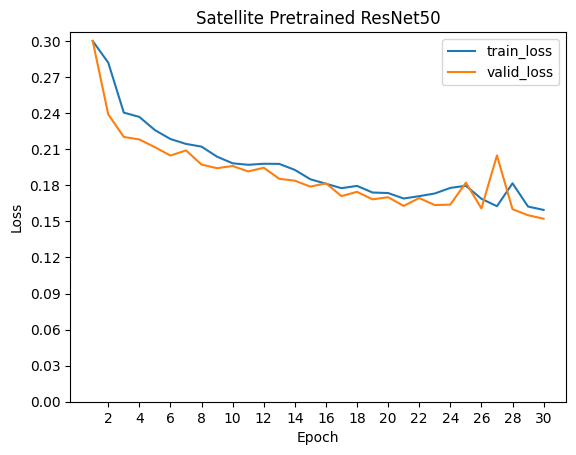

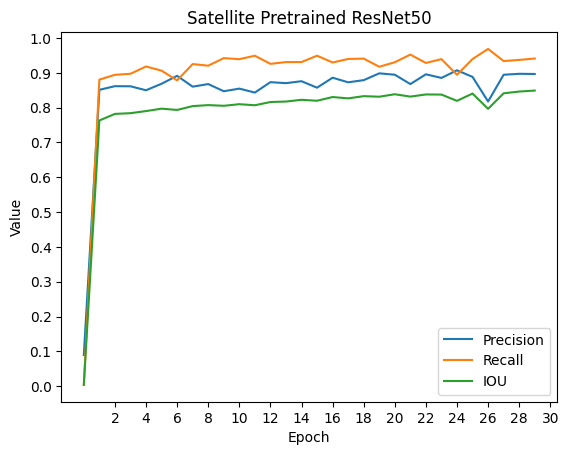

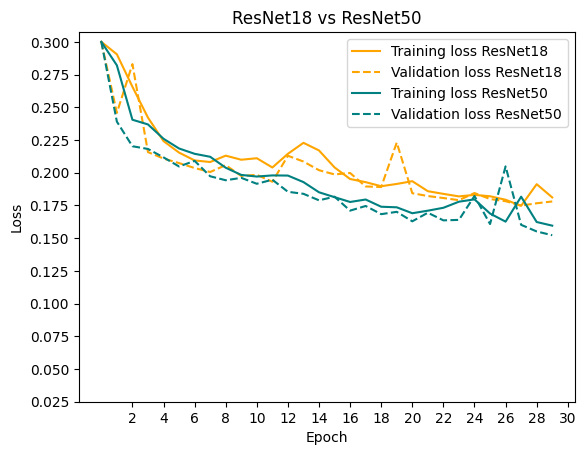

In [ ]:
plot_losses("Satellite Pretrained ResNet50", sat_resnet50_train, sat_resnet50_valid)
plot_metrics("Satellite Pretrained ResNet50", sat_resnet50_metrics)
plot_loss_comparison("ResNet18 vs ResNet50", sat_resnet18_train_jaccard, sat_resnet50_train, sat_resnet18_valid_jaccard, sat_resnet50_valid, compare1='ResNet18', compare2='ResNet50')

Better than smaller ResNet, but it takes about 10x longer to train. It does not seem to have fully converged either. From the way I built the decoder, I have a feeling it would perform better on larger sized images.

In [ ]:
# ImageNet ResNet50
loss = JaccardLoss()
imagenet_resnet50 = resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)

imagenet_resnet50_unet = ResNet_UNet(ResNet=imagenet_resnet50, input_image_size=128).to(DEVICE)
del imagenet_resnet50
imagenet_resnet50_train, imagenet_resnet50_metrics = train(imagenet_resnet50_unet, trainLoader, testLoader, loss)
imagenet_resnet50_valid = [x['Loss'] for x in imagenet_resnet50_metrics]
del imagenet_resnet50_unet

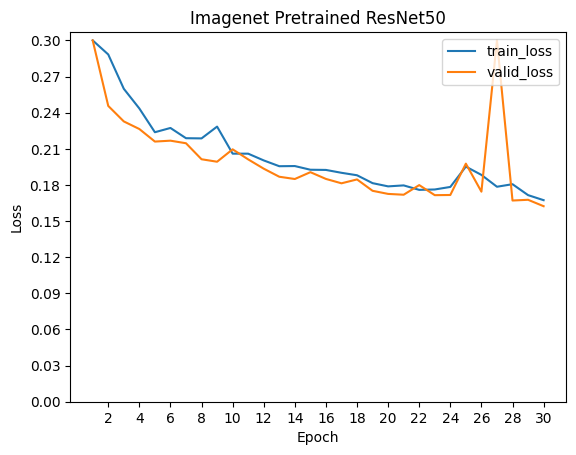

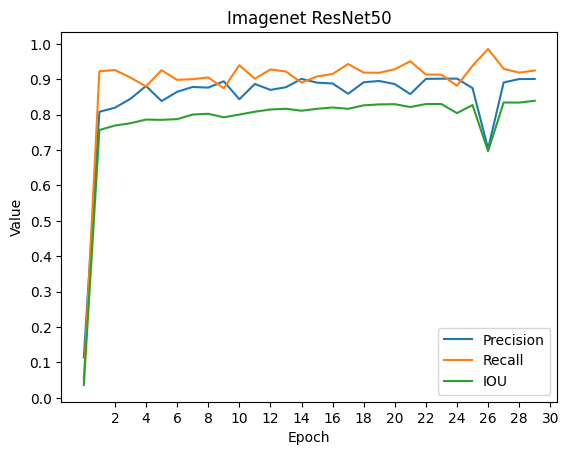

In [ ]:
plot_losses("Imagenet Pretrained ResNet50", imagenet_resnet50_train, imagenet_resnet50_valid)
plot_metrics("Imagenet ResNet50", imagenet_resnet50_metrics)

[[0.7445986637279962, 0.8871447336722723, 0.6801716326202317], [0.8892722772221734, 0.9179440480421696, 0.8237870146171179], [0.896740833411397, 0.9411674149021525, 0.8491417915491254], [0.9007822221742975, 0.9245049037675342, 0.8390625424176124]]


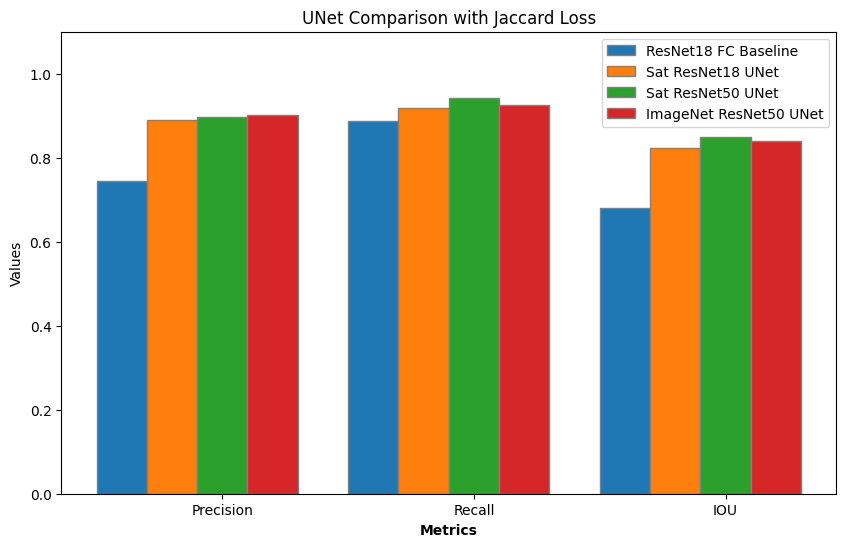

In [ ]:
# All ResNet Comparison
metrics = []
metrics.append(sat_resnet18_FC_metrics_jaccard)
metrics.append(sat_resnet18_metrics_jaccard)
metrics.append(sat_resnet50_metrics)
metrics.append(imagenet_resnet50_metrics)

# The FC model is the architecture from the 2020 mangrove monitoring paper, 
# so it is used as a baseline. It uses a resnet18 backbone and a fully connected layer for segmentation.
titles = ['ResNet18 FC Baseline', 'Sat ResNet18 UNet', 'Sat ResNet50 UNet', 'ImageNet ResNet50 UNet']

plot_comparison_metrics("UNet Comparison with Jaccard Loss", metrics, titles)

We can see that there is a negligible difference between the ResNet18 and ResNet50 backbones, despite the large difference in training time and size. The ResNet50 is over 2x larger and takes ~10x longer to train.

### Shifted Window Transformer

In [ ]:
# Model that uses a Swin Transformer backbone from Satlas.
# The Swin Transformer is pretrained on high-resolution drone imagery.
# This takes too long to train and is low accuracy, avoid using. We have simpler models that reach convergence.

# loss = JaccardLoss()
#swin_satlas = SwinB_UNet().to(DEVICE)
#train_swin, swin_metrics = train(swin_satlas, trainLoader, testLoader, loss, print_all_epochs=True)
#valid_swin = [x['Loss'] for x in swin_metrics]